In [3]:
import numpy as np
import matplotlib.pyplot as plt
import corrcal
import hera_sim
import healpy
from astropy import constants, units
from scipy.optimize import fmin_cg
from scipy import special
%matplotlib inline

In [4]:
def square_array(N, sep=14.6):
    array = {}
    for i in range(N):
        for j in range(N):
            array[i*N+j] = np.array([i*sep, j*sep, 0])
    return array

In [5]:
# array = square_array(4)
array = hera_sim.antpos.hex_array(3, split_core=False, outriggers=0)
channel_width = 9000
integration_time = 10.7
nu0 = 150e6

In [6]:
sim = hera_sim.Simulator(
    array_layout=array,
    Nfreqs=1,
    start_freq=nu0,
    channel_width=channel_width,
    Ntimes=1,
    start_time=2458055.3,
    integration_time=10.7,
)

Fixing phases using antenna positions.


In [7]:
# Pull some metadata for slicing through the array
uvdata = sim.data
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

Question: If I really want to respect the assumptions of CorrCal, then wouldn't the point source simulation actually draw the source amplitude from a Gaussian for each baseline?

In [8]:
# Rather than use actual data, take a few point sources.
src_za = np.array([4 * np.pi / 5, 0 * np.pi / 3, 1 * np.pi / 8])
src_az = np.array([np.pi / 3, 5 * np.pi / 3, 3 * np.pi / 4])
src_flux = np.array([3, 4, 2], dtype=float)
src_loc = np.array(
    [
        [np.sin(za)*np.cos(az), np.sin(za)*np.sin(az), np.cos(za)]
        for za, az in zip(src_za, src_az)
    ]
)
for i, (ai, aj) in enumerate(zip(ant_1_inds, ant_2_inds)):
    bl = antpos[aj] - antpos[ai]
    sim.data.data_array[i,...] = np.sum(
        src_flux * np.exp(
            -2j * np.pi * nu0 * src_loc @ bl / constants.c.si.value
        )
    )

In [9]:
# TODO: put the code for simulating visibilities of a GRF realization here

In [10]:
# Get a copy of the perfectly-calibrated data
true_uvdata = uvdata.copy()

In [11]:
# Add some noise
Trx = np.min(src_flux) / 100
sim.add(
    "thermal_noise",
    Trx=Trx,
    omega_p=np.ones_like(sim.freqs)*2*np.pi,
    autovis=src_flux.sum(),
    channel_width=channel_width,
    integration_time=integration_time,
)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


In [12]:
uvdata.select(ant_str="cross")
true_uvdata.select(ant_str="cross")

In [13]:
groups, centers, lengths = uvdata.get_redundancies()
bls_to_keep = []
for group in groups:
    if len(group) >= 5:
        bls_to_keep += group
uvdata.select(bls=bls_to_keep)
true_uvdata.select(bls=bls_to_keep)

In [14]:
# Pull the data array and the antenna metadata again.
data = uvdata.data_array[:,0,0,0].copy()
true_data = true_uvdata.data_array[:,0,0,0].copy()
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

In [15]:
# Sort the data into redundant groups.
wavelength = constants.c.si.value / nu0
uvws = (antpos[ant_2_inds] - antpos[ant_1_inds]) / wavelength
sort, edges, conj = corrcal.gridding.make_redundant_groups(*uvws.T[:2])
sorted_uvws = uvws[sort,:]
sorted_uvws[conj,:] *= -1
sorted_ant_1_inds = ant_1_inds[sort]
sorted_ant_2_inds = ant_2_inds[sort]
tmp = sorted_ant_1_inds.copy()
sorted_ant_1_inds[conj] = sorted_ant_2_inds[conj]
sorted_ant_2_inds[conj] = tmp[conj]
sorted_data = data[sort]
sorted_data[conj] = sorted_data[conj].conj()
sorted_true_data = true_data[sort]
sorted_true_data[conj] = sorted_true_data[conj].conj()

In [16]:
n_bls = true_uvdata.Nbls
split_data = np.zeros(2*n_bls, dtype=float)
split_data[::2] = sorted_data.real
split_data[1::2] = sorted_data.imag
split_true_data = np.zeros(2*n_bls, dtype=float)
split_true_data[::2] = sorted_true_data.real
split_true_data[1::2] = sorted_true_data.imag

In [17]:
# Insert a small amount of noise for invertibility.
Jy2T = 1e-26 * wavelength**2 / (2*constants.k_B.si.value*2*np.pi)
noise_amp = (src_flux.sum() + Trx/Jy2T)**2 / (channel_width*integration_time)
noise = noise_amp * np.eye(n_bls, dtype=complex)
noise_diag = np.diag(noise)
split_noise = np.ones(2*n_bls, dtype=float) * noise_amp / 2  # half of variance in real/imag each

n_groups = edges.size - 1
n_src = src_flux.size
diff_mat = np.zeros((n_bls, n_groups), dtype=complex)
split_diff_mat = np.zeros((2*n_bls, n_groups), dtype=float)
bls = antpos[sorted_ant_2_inds] - antpos[sorted_ant_1_inds]
src_mat = src_flux.reshape(1, -1) * np.exp(
    -2j * np.pi * nu0 * bls @ src_loc.T / constants.c.si.value
)
split_src_mat = np.zeros((2*n_bls, n_src), dtype=float)
split_src_mat[::2] = src_mat.real
split_src_mat[1::2] = src_mat.imag

# Now mock up antenna gains.
# np.random.seed(0)
n_ants = antnums.size
err = 0.1
re_gain = np.random.normal(loc=1, scale=err, size=n_ants)
im_gain = np.random.normal(loc=0, scale=err, size=n_ants)
split_gains = np.zeros((2*n_ants), dtype=float)
split_gains[::2] = re_gain
split_gains[1::2] = im_gain
gains = re_gain + 1j*im_gain
gain_mat = gains[sorted_ant_1_inds] * gains[sorted_ant_2_inds].conj()
split_gain_mat = np.zeros(2*n_bls, dtype=float)
split_gain_mat[::2] = gain_mat.real
split_gain_mat[1::2] = gain_mat.imag
check = np.zeros(2*n_bls, dtype=float)
check[::2] = split_gains[sorted_ant_1_inds*2] * split_gains[sorted_ant_2_inds*2] + split_gains[2*sorted_ant_1_inds+1] * split_gains[2*sorted_ant_2_inds+1]
check[1::2] = split_gains[sorted_ant_1_inds*2+1] * split_gains[sorted_ant_2_inds*2] - split_gains[sorted_ant_1_inds*2] * split_gains[sorted_ant_2_inds*2+1]
np.allclose(check, split_gain_mat)

True

In [18]:
x = np.random.normal(size=(10,10))
y = np.random.normal(size=10)
z = np.diag(y)
np.allclose(y[:,None] * x, z @ x), np.allclose(x * y[None,:], x @ z)

(True, True)

In [19]:
class Cov:
    def __init__(self, noise, diff_mat, src_mat, gains, edges, ant_1_inds, ant_2_inds):
        self.noise = noise
        self.diff_mat = diff_mat
        self.src_mat = src_mat
        self.gains = gains
        self.edges = edges
        self.ant_1_inds = ant_1_inds
        self.ant_2_inds = ant_2_inds
        self.n_bls = diff_mat.shape[0]
        self.n_grp = len(edges) - 1
        self.n_eig = diff_mat.shape[1] // self.n_grp
        self.n_src = src_mat.shape[1]
    
    def inv(self, dense=False, return_det=False):
        return self._dense_inv(return_det) if dense else self._sparse_inv(return_det)
    
    def _dense_inv(self, return_det=False):
        gain_mat = self.build_gain_mat()
        sky_cov = self.src_mat@self.src_mat.T.conj() + self.diff_mat@self.diff_mat.T.conj()
        full_cov = self.noise + gain_mat[:,None]*sky_cov*gain_mat[None,:].conj()
        inv = np.linalg.inv(full_cov)
        if return_det:
            try:
                logdet = 2*np.sum(np.log(np.diag(np.linalg.cholesky(full_cov))))
            except np.linalg.LinAlgError:
                logdet = np.inf
            return inv, np.real(logdet)
        return inv
    
    def _sparse_inv(self, return_det=False):
        if return_det:
            logdet = 0
            
        gain_mat = self.build_gain_mat()
        Cinv = np.zeros((self.n_bls, self.n_bls), dtype=complex)
        GD = gain_mat[:,None] * self.diff_mat
        for grp, (start, stop) in enumerate(zip(self.edges, self.edges[1:])):
            left = grp * self.n_eig
            right = left + self.n_eig
            
            block = GD[start:stop, left:right].copy()
            block = self.noise[start:stop,start:stop] + block@block.T.conj()
            if return_det:
                logdet += 2*np.sum(np.log(np.diag(np.linalg.cholesky(block))))
            Cinv[start:stop,start:stop] = np.linalg.inv(block)
            
        GS = gain_mat[:,None] * self.src_mat
        CGS = Cinv @ GS
        tmp = np.eye(self.n_src) + GS.T.conj()@CGS
        Cinv -= CGS @ np.linalg.inv(tmp) @ CGS.T.conj()
        
        if return_det:
            logdet += 2 * np.sum(np.log(np.diag(np.linalg.cholesky(tmp))))
            return Cinv, np.real(logdet)
        return Cinv
       
    def build_gain_mat(self):
        gains = self.gains[::2] + 1j*self.gains[1::2]
        return gains[self.ant_1_inds] * gains[self.ant_2_inds].conj()

In [20]:
def nll(gains, cov, data, scale=1, phs_norm_fac=1):
    """Negative log-likelihood."""
    cov.gains = gains / scale
    cinv, logdet = cov.inv(dense=False, return_det=True)
    chisq = data.conj() @ cinv @ data
    # Use a Gaussian prior that the phase should be nearly zero for all antennas
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    phs_norm = phases.sum()**2 / phs_norm_fac**2
#     phs_norm = cov.gains[1::2].sum()**2 / phs_norm_fac**2
    return np.real(chisq) + logdet + phs_norm

In [21]:
def grad_nll(gains, cov, data, scale=1, phs_norm_fac=1):
    """Gradient of negative log-likelihood."""
    cov.gains = gains / scale
    complex_gains = (gains[::2] + 1j*gains[1::2]) / scale
    gain_mat = cov.build_gain_mat()
    cinv = cov.inv(dense=False, return_det=False)
    cinv_data = cinv @ data
    grad_nll = np.zeros_like(gains)
    tan_phs = cov.gains[1::2] / cov.gains[::2]
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    grad_phs_prefac = 2 * phases.sum() / (phs_norm_fac**2 * cov.gains[::2] * (1+tan_phs**2))
    for k in range(gains.size):
        grad_chisq = 0
        grad_gains = np.zeros_like(gain_mat)
        if k%2 == 0:  # derivative wrt real gain
            grad_gains += np.where(cov.ant_1_inds == k//2, complex_gains[cov.ant_2_inds].conj(), 0)
            grad_gains += np.where(cov.ant_2_inds == k//2, complex_gains[cov.ant_1_inds], 0)
            grad_phs_norm = -grad_phs_prefac[k//2] * cov.gains[k+1] / cov.gains[k]
#             grad_phs_norm = 0
        else:
            grad_gains += np.where(cov.ant_1_inds == k//2, 1j*complex_gains[cov.ant_2_inds].conj(), 0)
            grad_gains += np.where(cov.ant_2_inds == k//2, -1j*complex_gains[cov.ant_1_inds], 0)
            grad_phs_norm = grad_phs_prefac[k//2]
#             grad_phs_norm = 2 * cov.gains[1::2].sum() / phs_norm_fac**2
        tmp1 = grad_gains[:,None] * cov.src_mat
        tmp2 = cov.src_mat.T.conj() * gain_mat[None,:].conj()
        grad_cov = tmp1 @ tmp2
        tmp1 = cinv_data.conj() @ tmp1
        tmp2 = tmp2 @ cinv_data
        grad_chisq += tmp1 @ tmp2
        tmp1 = grad_gains[:,None] * cov.diff_mat
        tmp2 = cov.diff_mat.T.conj() * gain_mat[None,:].conj()
        grad_cov += tmp1 @ tmp2
        tmp1 = cinv_data.conj() @ tmp1
        tmp2 = tmp2 @ cinv_data
        grad_chisq += tmp1 @ tmp2
        grad_cov = grad_cov + grad_cov.T.conj()
        grad_logdet = np.sum(cinv * grad_cov.T)
        grad_nll[k] = np.real(grad_logdet - 2*grad_chisq + grad_phs_norm)  # actually calculated -grad_chisq/2, so this is right
    return grad_nll / scale

In [22]:
def dense_nll(gains, cov, data, scale=1, phs_norm_fac=1):
    cov.gains = gains / scale
    cinv, logdet = cov.inv(dense=True, return_det=True)
    chisq = data.conj() @ cinv @ data
    # Use a Gaussian prior that the phase should be nearly zero for all antennas
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    phs_norm = phases.sum()**2 / phs_norm_fac**2
#     phs_norm = cov.gains[1::2].sum()**2 / phs_norm_fac**2
    return np.real(chisq) + logdet + phs_norm

In [23]:
def dense_grad_nll(gains, cov, data, scale=1, phs_norm_fac=1):
    cov.gains = gains / scale
    cinv = cov.inv(dense=True, return_det=False)
    gain_mat = cov.build_gain_mat()
    complex_gains = (gains[::2] + 1j*gains[1::2]) / scale
    cinv_data = cinv @ data
    sky_cov = cov.src_mat@cov.src_mat.T.conj() + cov.diff_mat@cov.diff_mat.T.conj()
    tan_phs = cov.gains[1::2] / cov.gains[::2]
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    grad_phs_prefac = 2 * phases.sum() / (phs_norm_fac**2 * cov.gains[::2] * (1+tan_phs**2))
    grad_nll = np.zeros_like(gains)
    for k in range(gains.size):
        grad_chisq = 0
        grad_gains = np.zeros_like(gain_mat)
        if k%2 == 0:  # derivative wrt real gain
            grad_gains += np.where(cov.ant_1_inds == k//2, complex_gains[cov.ant_2_inds].conj(), 0)
            grad_gains += np.where(cov.ant_2_inds == k//2, complex_gains[cov.ant_1_inds], 0)
            grad_phs_norm = -grad_phs_prefac[k//2] * cov.gains[k+1] / cov.gains[k]
#             grad_phs_norm = 0
        else:
            grad_gains += np.where(cov.ant_1_inds == k//2, 1j*complex_gains[cov.ant_2_inds].conj(), 0)
            grad_gains += np.where(cov.ant_2_inds == k//2, -1j*complex_gains[cov.ant_1_inds], 0)
            grad_phs_norm = grad_phs_prefac[k//2]
#             grad_phs_norm = 2 * cov.gains[1::2].sum() / phs_norm_fac**2
        grad_cov = grad_gains[:,None] * sky_cov * gain_mat[None,:].conj()
        grad_cov = grad_cov + grad_cov.T.conj()
        grad_chisq = cinv_data.conj() @ grad_cov @ cinv_data
        grad_logdet = np.sum(cinv * grad_cov.T)
        grad_nll[k] = np.real(grad_logdet - grad_chisq + grad_phs_norm)  # here we calculated -grad_chisq instead
    return grad_nll / scale

In [24]:
cov = Cov(
    noise=noise,
    diff_mat=diff_mat,
    src_mat=src_mat,
    gains=split_gains,
    edges=edges,
    ant_1_inds=sorted_ant_1_inds,
    ant_2_inds=sorted_ant_2_inds,
)

In [25]:
gain_mat = cov.build_gain_mat()
sky_cov = cov.src_mat@cov.src_mat.T.conj() + cov.diff_mat@cov.diff_mat.T.conj()
full_cov = cov.noise + gain_mat[:,None]*sky_cov*gain_mat[None,:].conj()
cinv = cov.inv(dense=False)
cinv_dense = cov.inv(dense=True)
np.allclose(full_cov @ cinv, np.eye(cinv.shape[0])), np.allclose(full_cov @ cinv, full_cov @ cinv_dense), np.allclose(cinv, cinv_dense)

(True, True, True)

In [26]:
noise_amp

0.0954397029709131

In [27]:
np.isclose(
    nll(split_gains, cov, sorted_data),
    dense_nll(split_gains, cov, sorted_data)
)

True

In [28]:
np.allclose(
    grad_nll(split_gains, cov, sorted_data),
    dense_grad_nll(split_gains, cov, sorted_data)
)

True

In [29]:
scale = 1
phs_norm_fac = 1e-1
gtol = 1e-5

In [30]:
dense_fit, dense_steps = fmin_cg(
    f=dense_nll,
    x0=scale*split_gains,
    fprime=dense_grad_nll,
    gtol=gtol,
    args=[cov, sorted_true_data, scale, phs_norm_fac],
    retall=True,
)

         Current function value: -286.216601
         Iterations: 179
         Function evaluations: 318
         Gradient evaluations: 306


In [31]:
sparse_fit, sparse_steps = fmin_cg(
    f=nll,
    x0=scale*split_gains,
    fprime=grad_nll,
    gtol=gtol,
    args=[cov, sorted_true_data, scale, phs_norm_fac],
    retall=True,
)

         Current function value: -286.216601
         Iterations: 181
         Function evaluations: 469
         Gradient evaluations: 454


In [32]:
true_gains = np.zeros_like(cov.gains)
true_gains[::2] = 1

In [33]:
cov.gains = dense_fit / scale
# cov.gains = sparse_fit / scale
cinv, logdet = cov.inv(return_det=True)
chisq = sorted_true_data.conj() @ cinv @ sorted_true_data
cov.gains = true_gains
cinv, true_logdet = cov.inv(return_det=True)
true_chisq = sorted_true_data.conj() @ cinv @ sorted_true_data
expected_ratio = 4 * np.abs(np.mean(dense_fit[::2]/scale - true_gains[::2]))
# expected_ratio = 4 * np.abs(np.mean(sparse_fit[::2]/scale - true_gains[::2]))
np.abs(chisq - true_chisq) / true_chisq.real, expected_ratio

(0.00013608629366432408, 0.00014098782343038122)

In [34]:
logdet - true_logdet, np.real(chisq - true_chisq)

(-0.0004226209941293746, 0.0004082049971345647)

In [35]:
logdet, n_bls * np.log(noise_amp)# + np.log(1 + noise_amp * src_flux.sum()**2 * n_bls * np.mean(np.abs(dense_fit[::2]+1j*dense_fit[1::2])/scale)**4)

(-289.21661323137545, -317.150182809655)

In [36]:
nll(dense_fit, cov, sorted_true_data, scale, phs_norm_fac)

-286.21660097998216

In [37]:
nll(true_gains, cov, sorted_true_data, 1, phs_norm_fac)

-286.2165865639851

In [38]:
cov.gains = dense_fit / scale
logdet = cov.inv(return_det=True)[1]
logdet

-289.21661323137545

In [39]:
chisq.real

3.00001225139331

In [40]:
# results = {}
# for exp in np.arange(-5,6):
#     alpha = 10.0**exp
#     cov.gains = true_gains * alpha
#     cinv, logdet = cov.inv(return_det=True)
#     chisq = sorted_data.conj() @ cinv @ sorted_data
#     results[alpha] = (chisq, logdet, np.real(chisq)+logdet)
# results

In [41]:
# results = {}
# for angle in np.linspace(0, 2*np.pi, 10, endpoint=False):
#     test_gains = np.zeros_like(split_gains)
#     test_gains[::2] = 1
#     test_gains[1::2] = 0
#     test_gains[0] = np.cos(angle)
#     test_gains[1] = np.sin(angle)
#     cov.gains = test_gains
#     cinv, logdet = cov.inv(return_det=True)
#     chisq = sorted_data.conj() @ cinv @ sorted_data
#     results[angle] = (chisq, logdet, np.real(chisq)+logdet)
# results

In [42]:
# nsamples_per_ant = np.zeros(n_ants, dtype=int)
# for i in range(n_ants):
#     nsamples_per_ant[i] += np.sum(ant_1_inds==i) + np.sum(ant_2_inds==i)
# nsamples_per_ant

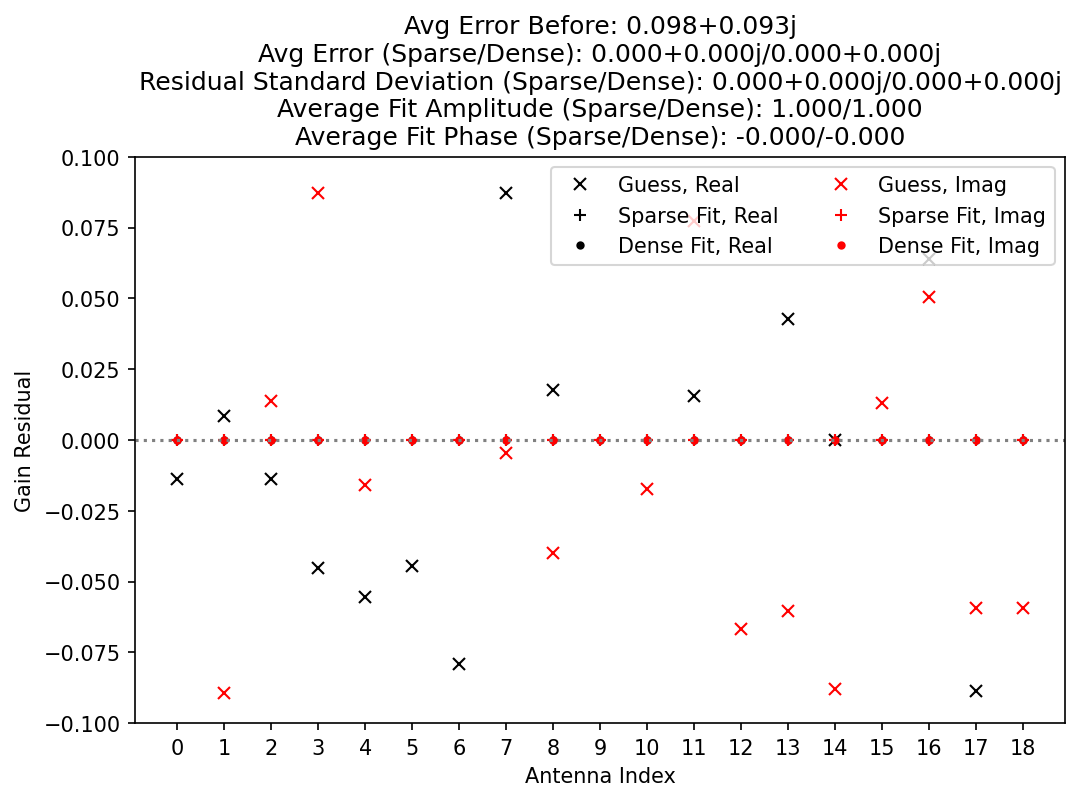

In [43]:
n_ants = gains.size
sfit = (sparse_fit[::2] + 1j*sparse_fit[1::2]) / scale
dfit = (dense_fit[::2] + 1j*dense_fit[1::2]) / scale
# If rephasing is desired:
# sfit *= sfit[0].conj() / np.abs(sfit[0])
# dfit *= dfit[0].conj() / np.abs(dfit[0])
def err(val, exp):
    return np.sqrt(np.mean((val - exp)**2))
avg_err_before = err(gains.real, 1) + 1j*err(gains.imag, 0)
avg_err_dense = err(dfit.real, 1) + 1j*err(dfit.imag, 0)
avg_err_sparse = err(sfit.real, 1) + 1j*err(sfit.imag, 0)
sfit_std = np.std(sfit.real) + 1j*np.std(sfit.imag)
dfit_std = np.std(dfit.real) + 1j*np.std(dfit.imag)
lim = 0.1
plt.figure(figsize=(8,5),dpi=150, facecolor='white')
title = f"Avg Error Before: {avg_err_before:.3f}\n"
title += f"Avg Error (Sparse/Dense): {avg_err_sparse:.3f}/{avg_err_dense:.3f}\n"
title += f"Residual Standard Deviation (Sparse/Dense): {sfit_std:.3f}/{dfit_std:.3f}\n"
title += f"Average Fit Amplitude (Sparse/Dense): {np.mean(np.abs(sfit)):.3f}/{np.mean(np.abs(dfit)):.3f}\n"
title += f"Average Fit Phase (Sparse/Dense): {np.mean(np.angle(sfit)):.3f}/{np.mean(np.angle(dfit)):.3f}"
plt.title(title)
plt.plot(gains.real - 1, 'kx', label='Guess, Real')
plt.plot(sfit.real - 1, 'k+', label='Sparse Fit, Real')
plt.plot(dfit.real - 1, 'k.', label='Dense Fit, Real')
plt.plot(gains.imag, 'rx', label='Guess, Imag')
plt.plot(sfit.imag, 'r+', label='Sparse Fit, Imag')
plt.plot(dfit.imag, 'r.', label='Dense Fit, Imag')
plt.ylim(-lim,lim)
plt.axhline(0, color='gray', ls=':')
plt.legend(ncol=2)
plt.xlabel("Antenna Index")
plt.ylabel("Gain Residual")
plt.xticks(np.arange(n_ants));
# plt.savefig(f"example_sol_comparison_complex_src_mat_only_zenith_src_scale_{scale}.png", dpi=150, bbox_inches='tight')
# plt.savefig("example_three_src_sol_with_noise.png", dpi=150, bbox_inches="tight")

In [44]:
offsets = np.linspace(-0.05, 0.05, 500)
nll_vals = np.zeros_like(offsets)
for i, offset in enumerate(offsets):
    sample_gains = true_gains.copy()
    sample_gains[::2] += offset
    nll_vals[i] = nll(sample_gains, cov, sorted_data, 1, phs_norm_fac)

Text(0.5, 0, '$\\delta$')

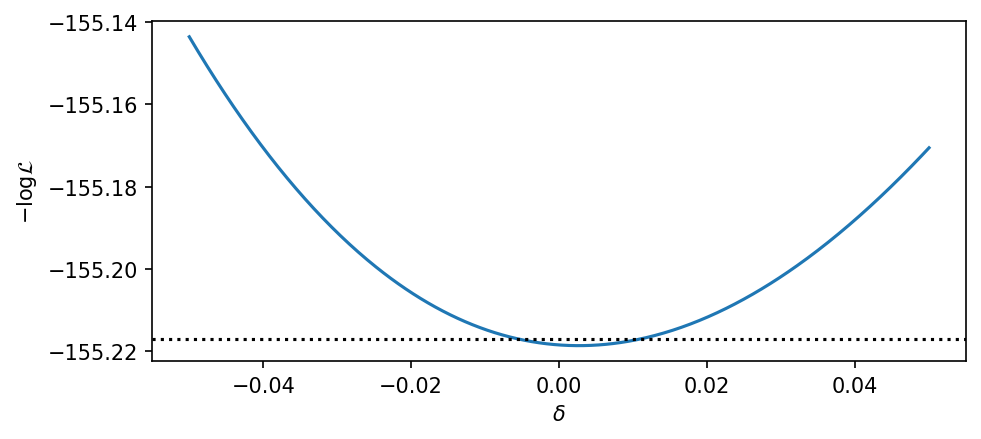

In [45]:
plt.figure(figsize=(7,3), dpi=150, facecolor='w')
thresh = (1 - 1e-5) * nll_vals.min()
plt.plot(offsets, nll_vals)
plt.axhline(thresh, color='k', ls=':')
plt.ylabel(r"$-\log\mathcal{L}$")
plt.xlabel(r"$\delta$")
# plt.savefig("nll_vs_gain_offset_two_src.png", dpi=150, bbox_inches='tight')

In [47]:
plt.errorbar?

Text(0, 0.5, '${\\rm \\bf Test\\ 1}$\n\nEstimated Signal Loss')

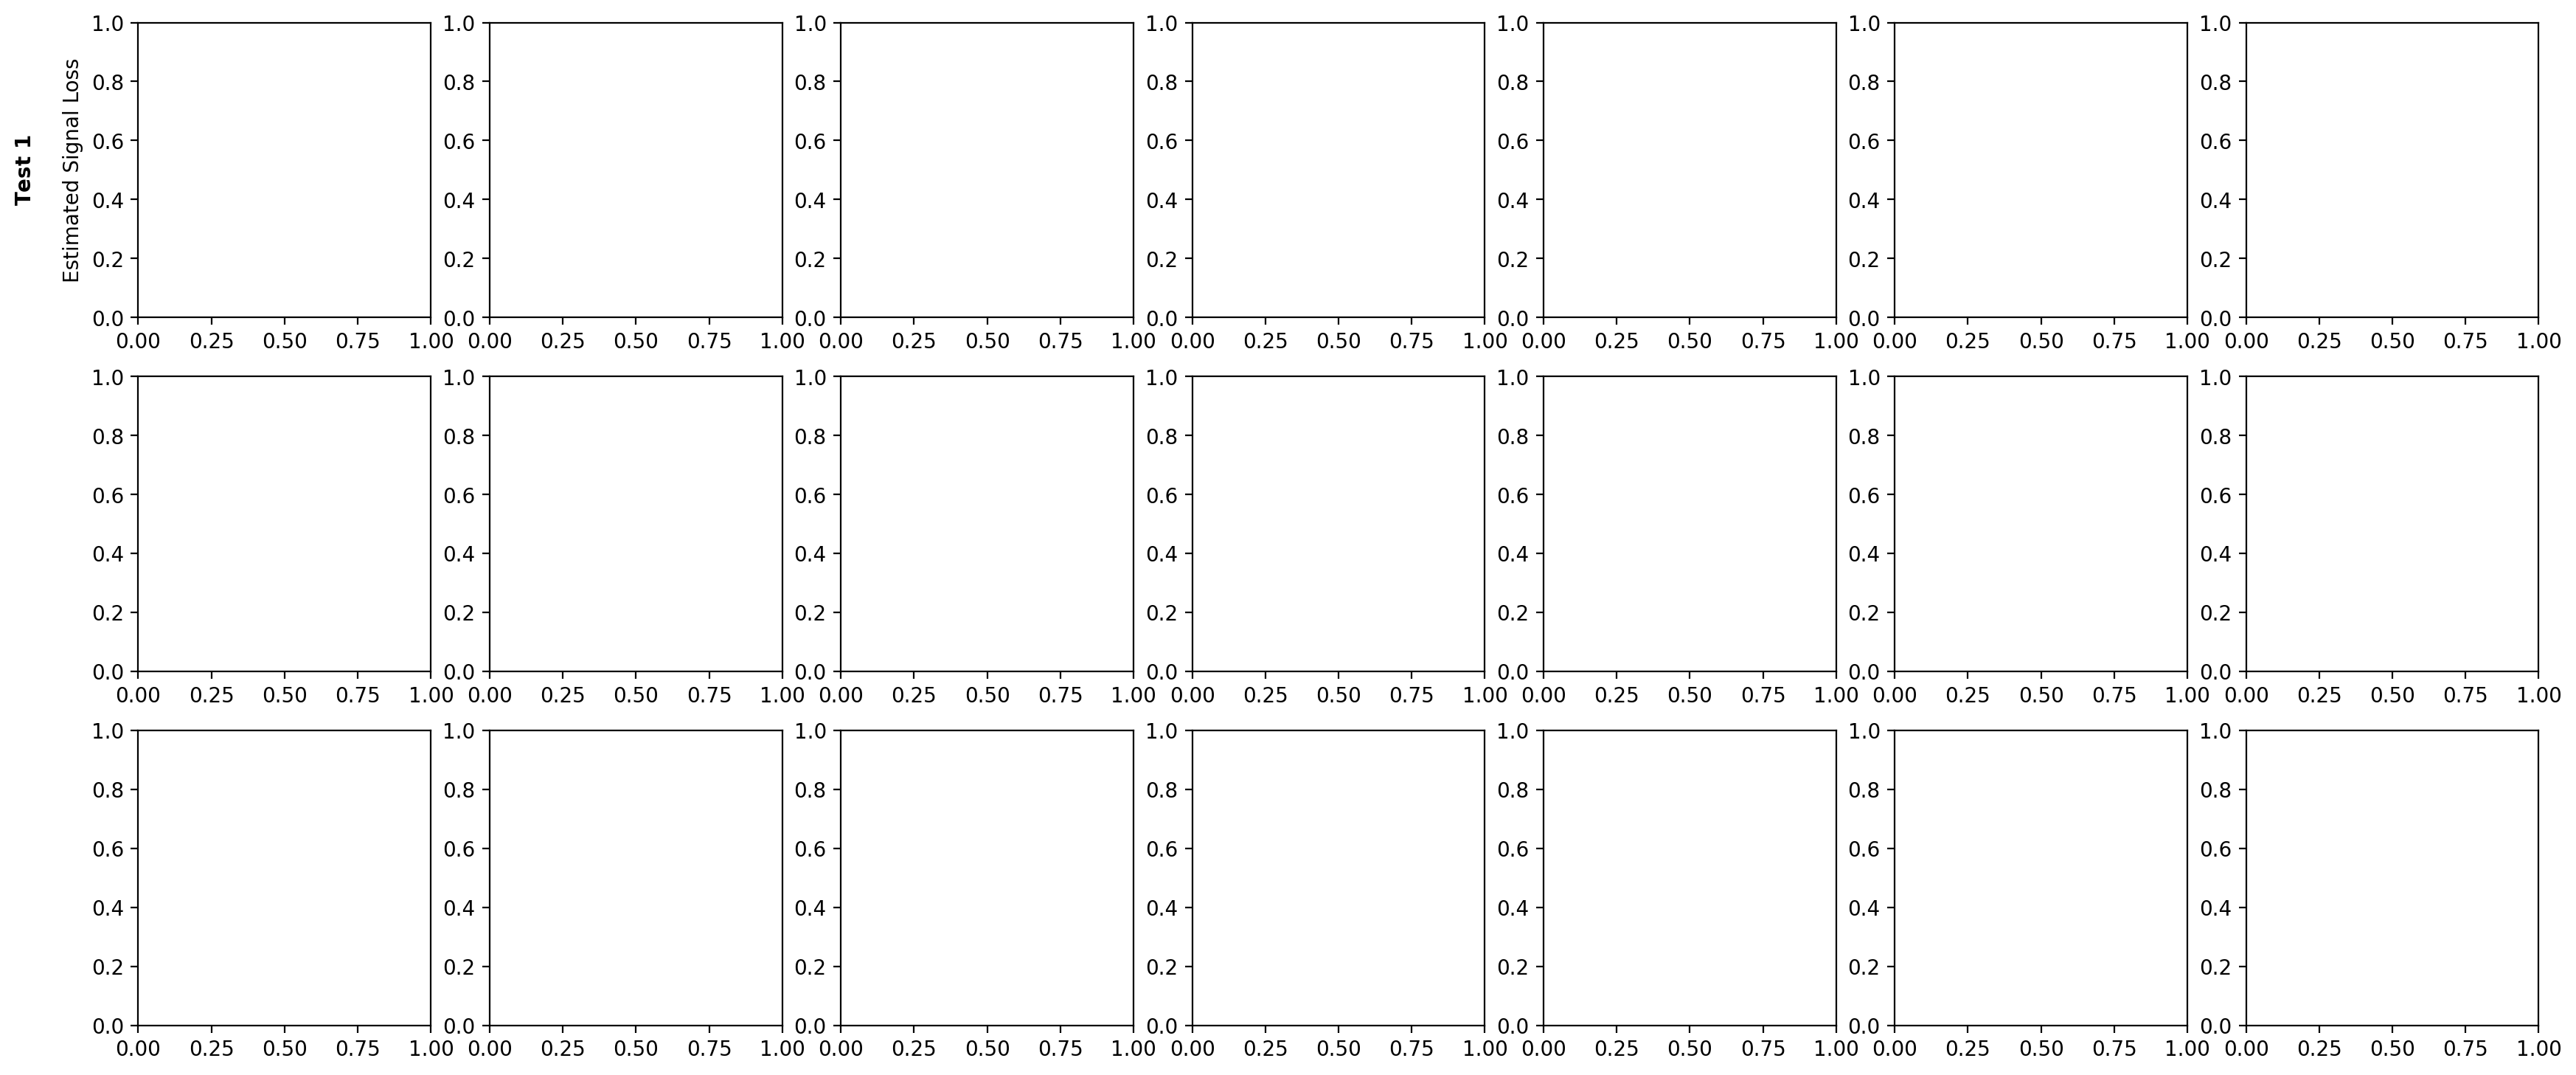

In [55]:
fig, axes = plt.subplots(nrows=3, ncols=7, dpi=200, figsize=(21,9), facecolor='w')
t = "Test 1"
axes[0,0].set_ylabel(r"${\rm \bf Test\ 1}$"+"\n"*2+"Estimated Signal Loss")